Files in zip: ['realtor-data.zip.csv']
   brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  


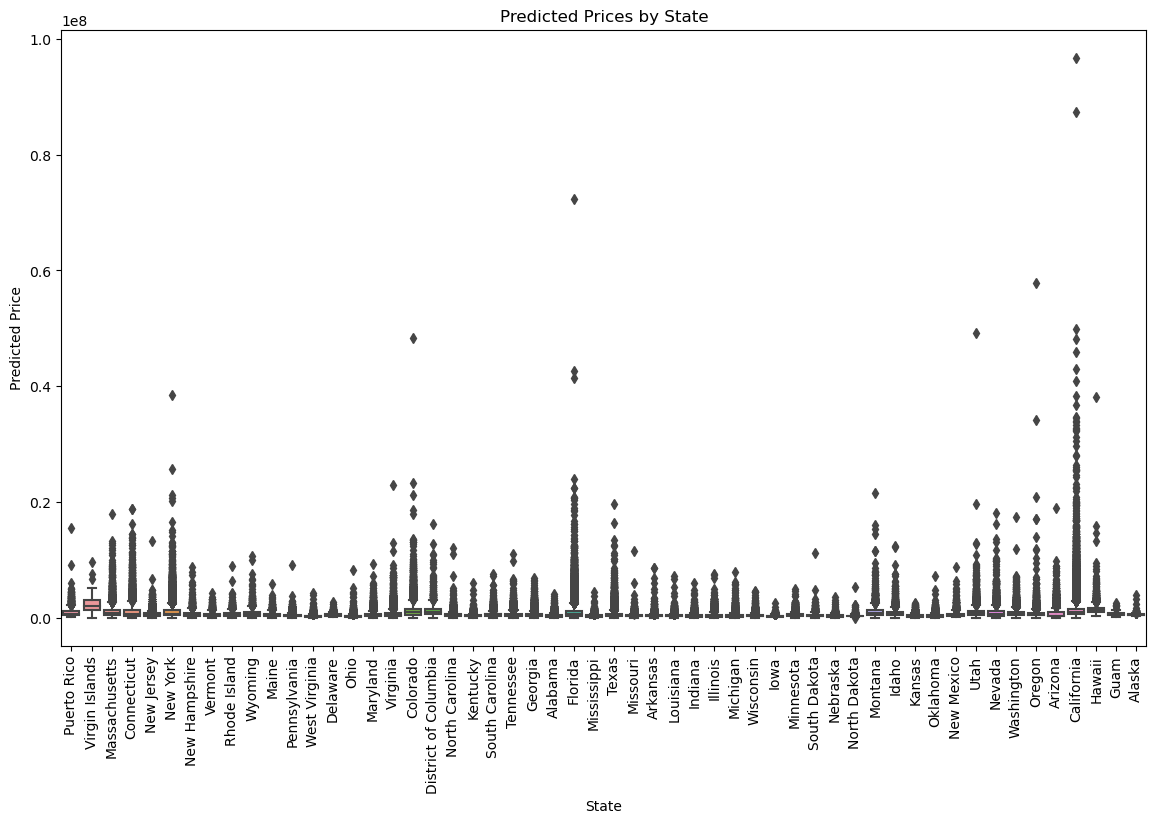

Number of observations after removing extreme outliers: 658423
[ 6061.52245572 52177.5199748   -207.65847772    71.90177627]
Predicted price for the house in California: $593357.10
Predicted price for the house in Texas: $502893.56
Predicted price for the house in Florida: $348708.03


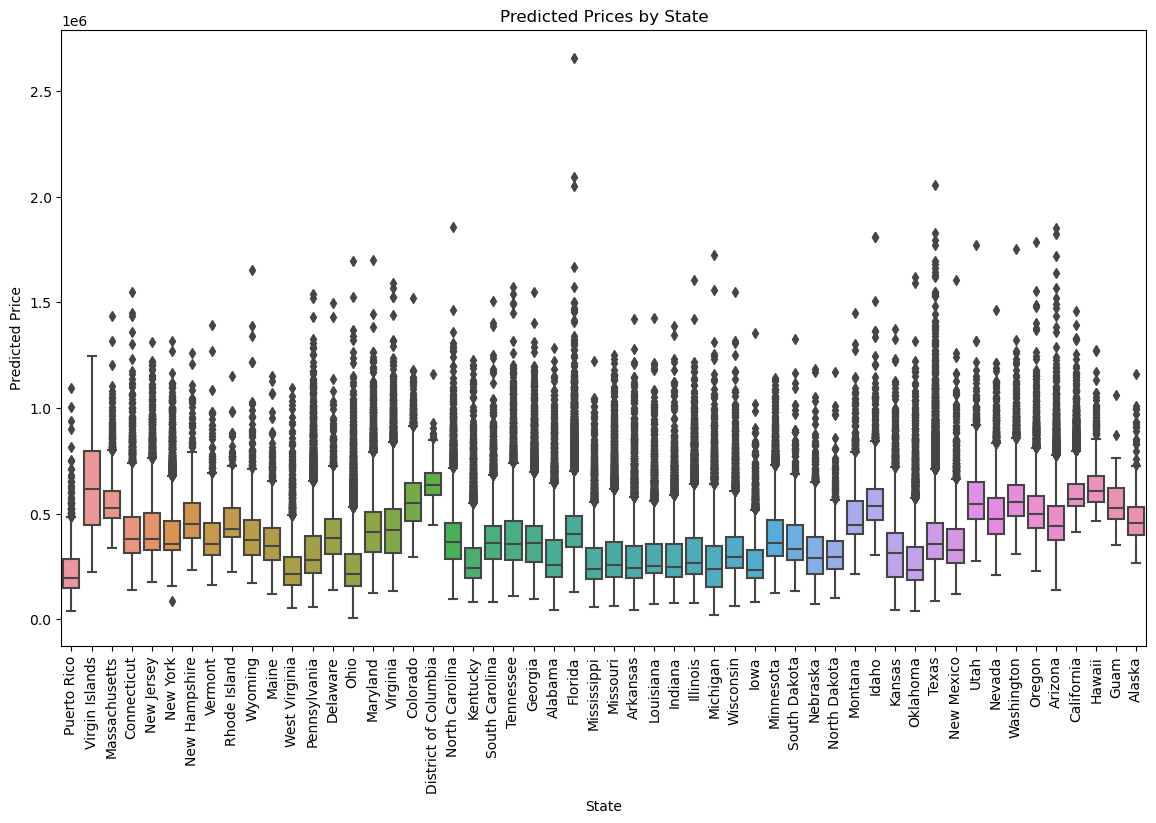

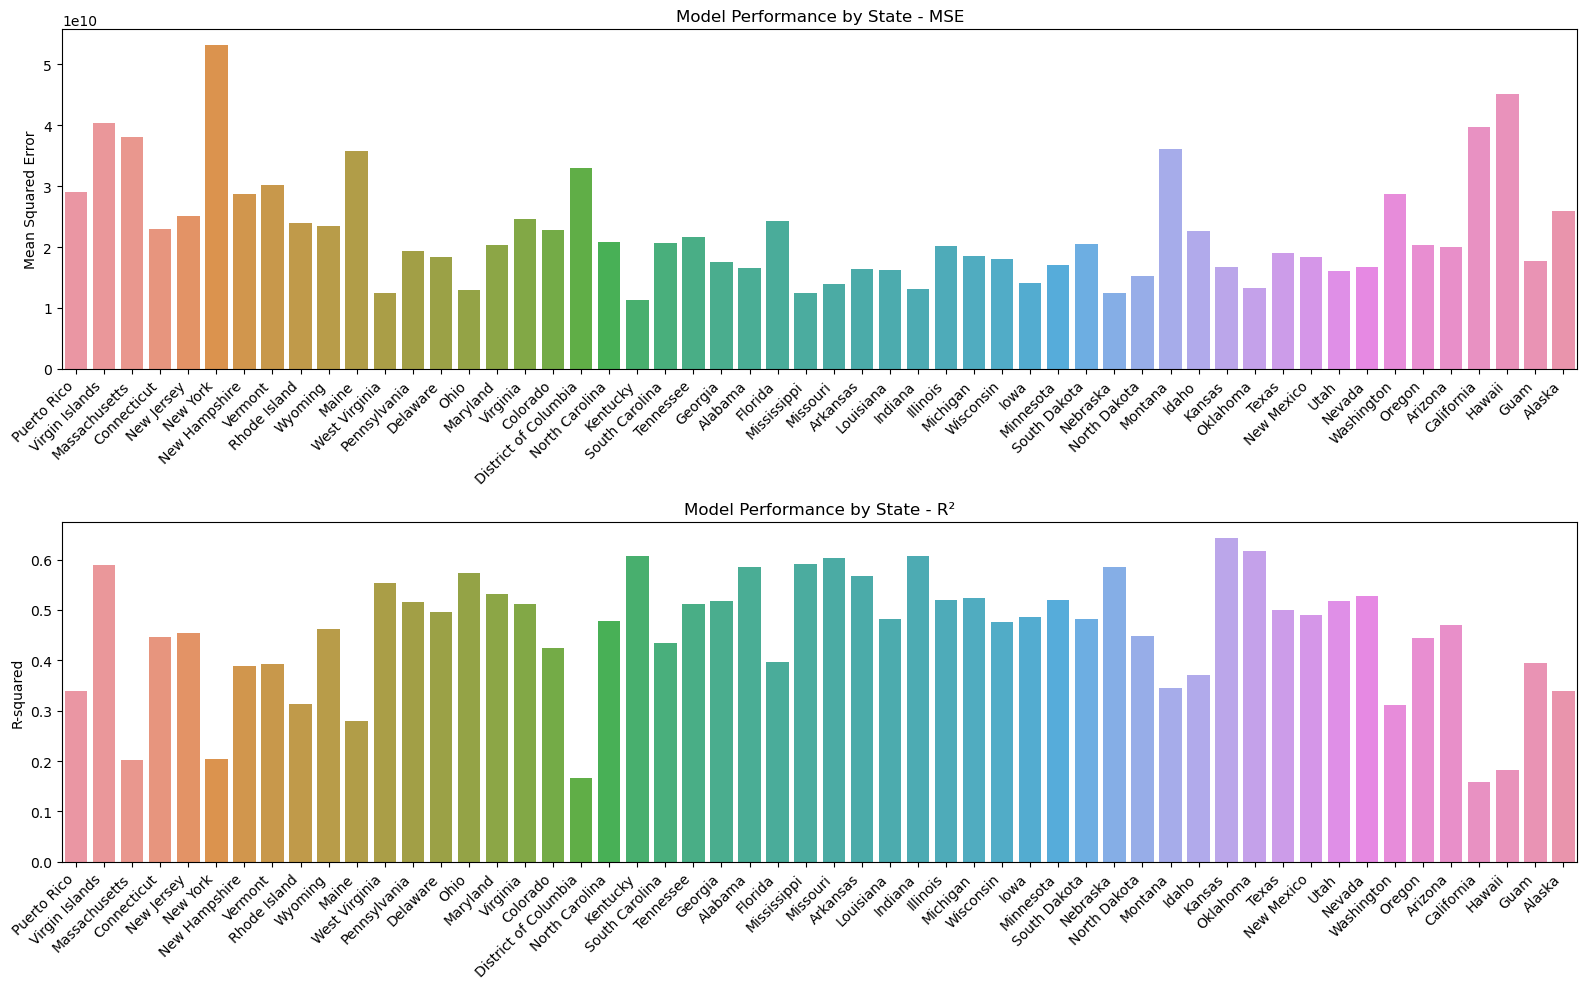


Statsmodels OLS Regression Results for California:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     2106.
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        00:24:42   Log-Likelihood:            -6.1354e+05
No. Observations:               45042   AIC:                         1.227e+06
Df Residuals:                   45037   BIC:                         1.227e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


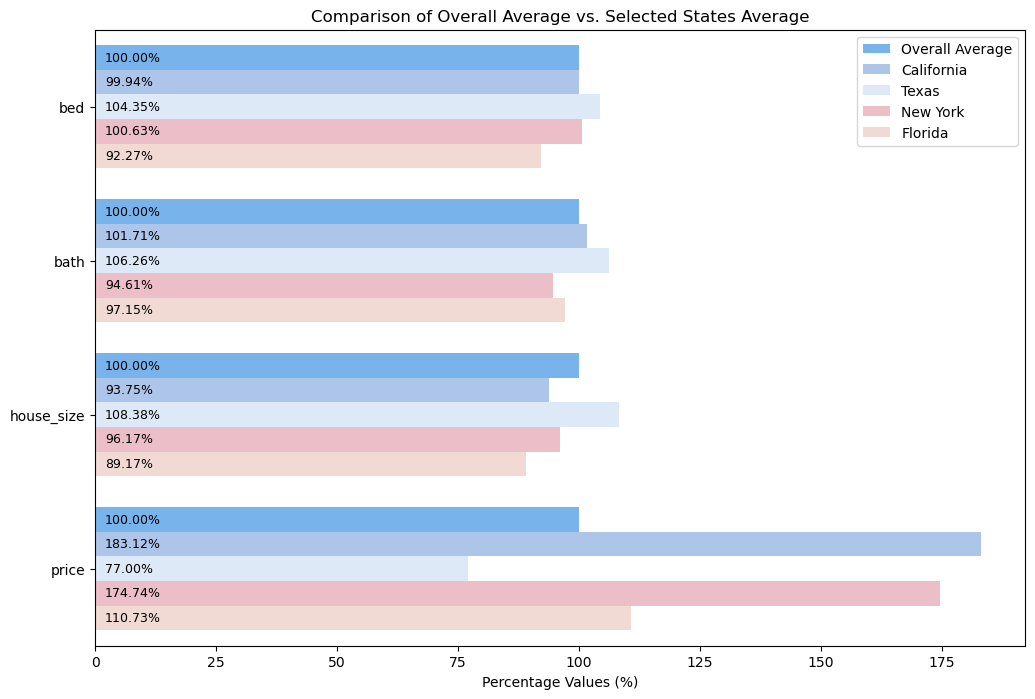

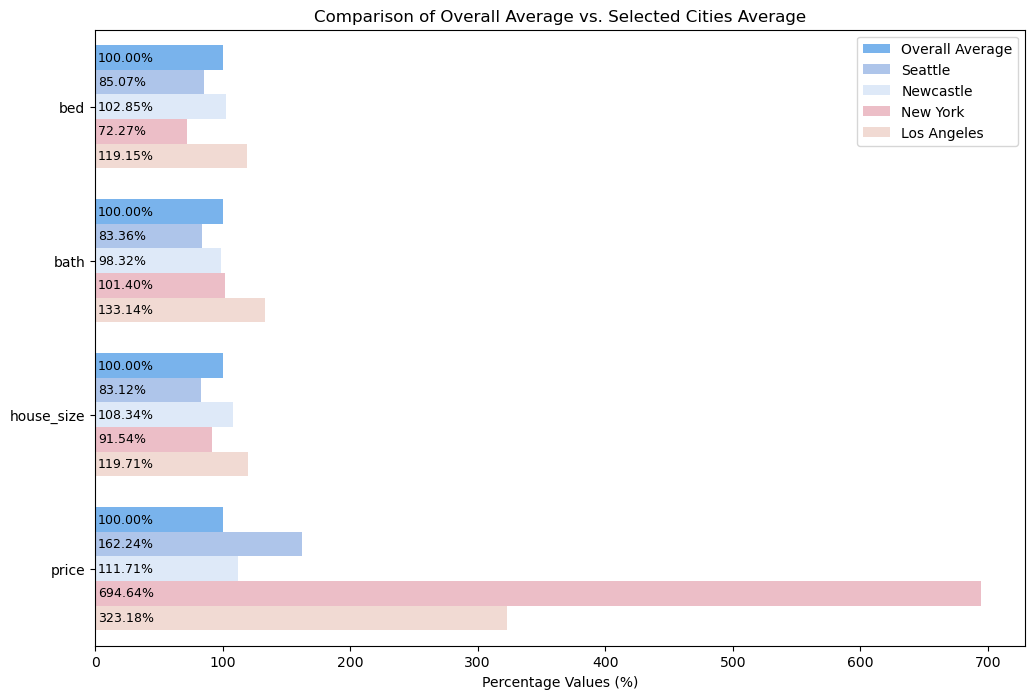

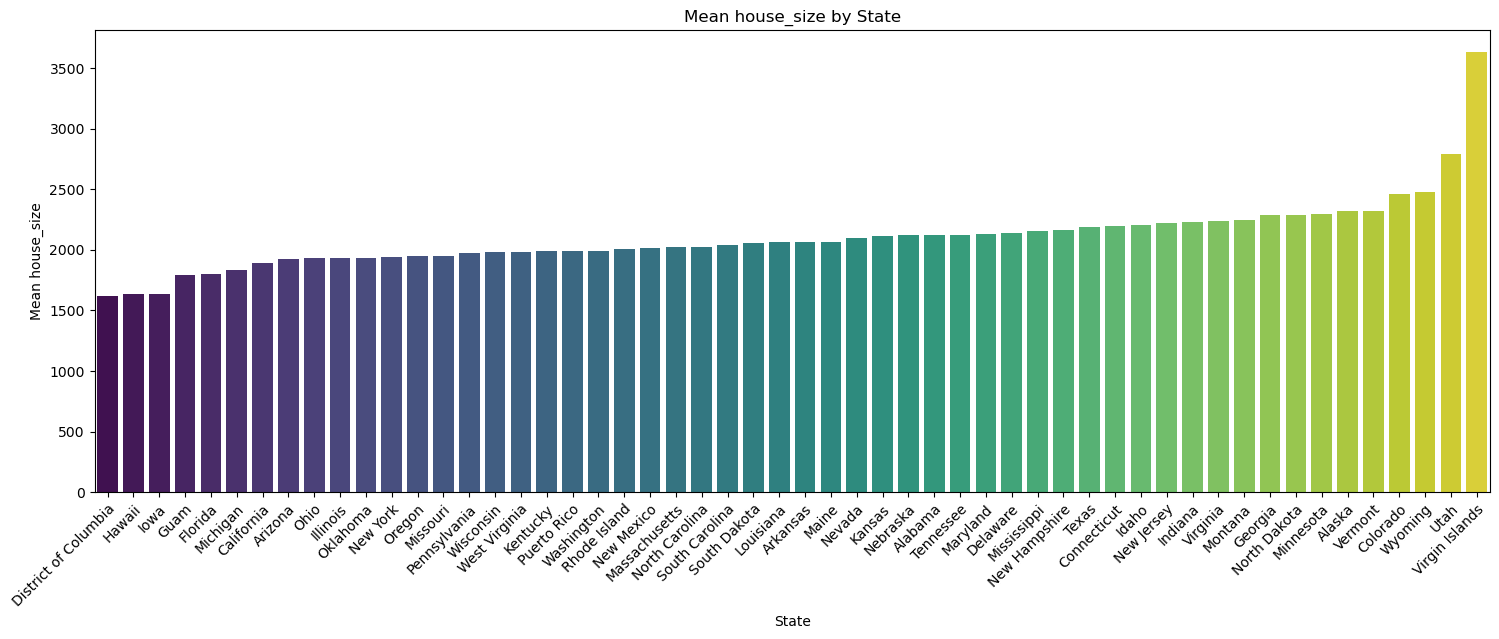

,city,bed,bath,house_size,price,state,zip_code
0,Hackberry,1.00,1.00,712.00,165000.00,Arizona,86411
1,Whetstone,2.00,2.00,800.00,139900.00,Arizona,85616
2,Bullhead,2.00,1.00,850.00,119900.00,Arizona,86442
3,Ehrenberg,3.00,2.33,914.67,139600.00,Arizona,85334
4,Guadalupe,2.50,1.50,924.00,199950.00,Arizona,85283
...,...,...,...,...,...,...,...
210,Nutrioso,3.50,3.00,3653.00,685000.00,Arizona,85932
211,Blue,6.00,8.00,4000.00,3500000.00,Arizona,85922
212,Paradise Valley,4.45,5.35,5944.55,5302004.91,Arizona,85253
213,Colorado City,6.50,5.00,6830.00,537000.00,Arizona,86021


In [1]:
### Required imports
import pandas as pd
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # For detailed regression summary


### Katherine Wei
### 1. What is the approximate selling price of a house given some specific characteristics?
### Load Data
# Define the path to the zip file and the name of the CSV file within the zip
zip_file_path = 'usa-real-estate-dataset.zip'
csv_file_name = 'realtor-data.zip.csv'  # Adjust if the file name inside the zip is different

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the zip archive (optional)
    print("Files in zip:", zip_ref.namelist())

    # Read the CSV file into a pandas DataFrame
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)
        print(df.head())  # Display the first few rows of the DataFrame

### Function to clean the data
def clean_data(df):
    df_cleaned = df.copy()
    df_cleaned['status'] = df_cleaned['status'].apply(lambda x: 1 if x == 'for_sale' else 0)
    df_cleaned = df_cleaned[df_cleaned['status'] == 1]

    df_cleaned.drop(columns=['prev_sold_date', 'street'], inplace=True)
    df_cleaned.dropna(inplace=True)

    return df_cleaned

df_cleaned = clean_data(df)

# Function to fit Linear Regression models for each state
def fit_state_models(df, features, target):
    state_models = {}
    for state in df['state'].unique():
        state_df = df[df['state'] == state].copy()
        if len(state_df) < 10:
            continue

        X_state = state_df[features]
        y_state = state_df[target]

        model = LinearRegression(fit_intercept=True)
        model.fit(X_state, y_state)

        state_df['predicted_price'] = model.predict(X_state)

        mse = mean_squared_error(y_state, state_df['predicted_price'])
        r2 = r2_score(y_state, state_df['predicted_price'])

        state_models[state] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'predicted_prices': state_df[['price', 'predicted_price']]
        }

    return state_models

features = ['bed', 'bath', 'acre_lot', 'house_size']
target = 'price'
state_models = fit_state_models(df_cleaned, features, target)

# Function to plot predicted prices by state
def plot_predicted_prices_by_state(state_models):
    predicted_prices = []
    states = []
    
    for state, results in state_models.items():
        preds = results['predicted_prices']['predicted_price']
        # Filter out values less than zero
        preds = preds[preds >= 0]
        predicted_prices.extend(preds)
        states.extend([state] * len(preds))
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=states, y=predicted_prices)
    plt.xlabel('State')
    plt.ylabel('Predicted Price')
    plt.title('Predicted Prices by State')
    plt.xticks(rotation=90)
    plt.show()

plot_predicted_prices_by_state(state_models)

### Function to plot model performance by state
def plot_model_performance(state_models):
    states = []
    mses = []
    r2s = []
    
    for state, metrics in state_models.items():
        states.append(state)
        mses.append(metrics['mse'])
        r2s.append(metrics['r2'])
    
    plt.figure(figsize=(16, 10))
    
    # MSE bar chart
    plt.subplot(2, 1, 1)
    sns.barplot(x=states, y=mses)
    plt.ylabel('Mean Squared Error')
    plt.title('Model Performance by State - MSE')
    plt.xticks(rotation=45, ha='right')  # Rotate state names and align right
    
    # R² bar chart
    plt.subplot(2, 1, 2)
    sns.barplot(x=states, y=r2s)
    plt.ylabel('R-squared')
    plt.title('Model Performance by State - R²')
    plt.xticks(rotation=45, ha='right')  # Rotate state names and align right
    
    plt.tight_layout()
    plt.show()

# Function to predict price based on specific characteristics
def predict_price(state_models, state, bed, bath, acre_lot, house_size):
    if state not in state_models:
        raise ValueError(f"No model found for state: {state}")

    model = state_models[state]['model']
    input_data = pd.DataFrame({
        'bed': [bed],
        'bath': [bath],
        'acre_lot': [acre_lot],
        'house_size': [house_size]
    })

    predicted_price = model.predict(input_data)
    return predicted_price[0]

# Function to display regression results for California using statsmodels
def display_california_regression_results_sm(df, features, target):
    california_df = df[df['state'] == 'California']
    X_california = california_df[features]
    y_california = california_df[target]

    # Add a constant to the independent variables matrix (for the intercept)
    X_california = sm.add_constant(X_california)

    # Fit the regression model
    model = sm.OLS(y_california, X_california).fit()

    # Print the regression results
    print(model.summary())

# Main function to orchestrate the process
def main():
    df_cleaned = clean_data(df)

    features = ['bed', 'bath', 'acre_lot', 'house_size']
    target = 'price'

    # Remove properties with extreme values based on provided criteria
    df_cleaned_no_extreme_data = df_cleaned[df_cleaned['bed'] <= 10]
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['bed'] >= 2]
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['bath'] <= 10]
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['acre_lot'] <= 500]
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['house_size'] <= 15000]
    df_cleaned_no_extreme_data = df_cleaned_no_extreme_data[df_cleaned_no_extreme_data['price'] <= 10**6]

    print(f"Number of observations after removing extreme outliers: {len(df_cleaned_no_extreme_data)}")

    # Fit state models without extreme outliers
    state_models = fit_state_models(df_cleaned_no_extreme_data, features, target)
    print(state_models['California']['model'].coef_)

    # Show three examples of how the predict model works
    predicted_price = predict_price(state_models, 'California', 3, 2, 0.25, 2000)
    print(f"Predicted price for the house in California: ${predicted_price:.2f}")
    predicted_price = predict_price(state_models, 'Texas', 4, 3, 0.5, 3000)
    print(f"Predicted price for the house in Texas: ${predicted_price:.2f}")
    predicted_price = predict_price(state_models, 'Florida', 2, 1, 0.1, 1500)
    print(f"Predicted price for the house in Florida: ${predicted_price:.2f}")

    # Visualization 
    plot_predicted_prices_by_state(state_models)
    plot_model_performance(state_models)

    # Display regression results for California using statsmodels
    print("\nStatsmodels OLS Regression Results for California:")
    display_california_regression_results_sm(df_cleaned_no_extreme_data, features, target)

if __name__ == "__main__":
    main()


### Yan


### John X
# %% [markdown]
# ## 3. Advantage and Disadvantage of Houses by Location.

# %%
# Filter the DataFrame to include only the columns of interest
df_3 = df[['bed', 'bath', 'house_size', 'price', 'city', 'state', 'zip_code']]

# Remove rows where house_size is greater than 100,000
df_3 = df_3[df_3['house_size'] <= 100000]

# Remove rows that contain N/A values in all columns except 'zip_code'
df_3 = df_3.dropna(subset=['bed', 'bath', 'house_size', 'price', 'city', 'state'])

# Convert the zip_code column to 5-digit strings
df_3['zip_code'] = df_3['zip_code'].apply(lambda x: f'{int(x):05}' if pd.notna(x) else 'N/A')

# Display the first few rows of the filtered DataFrame
print(df_3.head())

# %%
class Database:
    def __init__(self, df):
        self.df = df
        
    def overall_avg():
        # Calculate the overall average of price, bed, bath, and house_size
        df_3_overall_average_values = df_3[['price', 'house_size', 'bed', 'bath']].mean()
        return df_3_overall_average_values
    
    def palette_3():
            # Lighter color palette
        palette = [
            '#66b3ff',  # light blue
            '#a4c2f4',  # light periwinkle
            '#dae8fc',  # light sky blue
            '#f4b6c2',  # light pink
            '#f6d8ce',  # light peach
            '#ffcc99',  # light orange
            '#fff2cc',  # light yellow
            '#b6d7a8',  # light sage
            '#c3d69b',  # light olive
            '#99ff99',  # light green
            '#ff9999'   # light red
        ]
        return palette

Database.overall_avg()

# %% [markdown]
# ### By State

# %%
def overall_compare_by_states(*states):
    '''
    This function compares the average price, bed, bath, and house size of the selected states with the overall average.
    '''
    # Calculate the overall average values
    overall_avg_values = Database.overall_avg()

    # Create a DataFrame to hold the comparison values
    comparison_df_graph = pd.DataFrame({'Overall Average': 100}, index=['bed', 'bath', 'house_size', 'price'])

    # Create a DataFrame to hold the raw values
    comparison_df = pd.DataFrame({'Overall Average': overall_avg_values})

    for state in states:
        # Filter the DataFrame to include only rows for the current state
        df_filtered_state = df_3[df_3['state'] == state]
        
        # Calculate the average values for the current state
        state_avg_values = df_filtered_state[['bed', 'bath', 'house_size', 'price']].mean()
        
        # Normalize the values by dividing by the overall average and multiplying by 100 to get percentages
        state_avg_values_percentage = (state_avg_values / overall_avg_values) * 100
        
        # Add the state's average values to the comparison DataFrame
        comparison_df[state] = state_avg_values
        comparison_df_graph[state] = state_avg_values_percentage

    # Set display options to avoid scientific notation
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    # Melt the DataFrame for seaborn
    comparison_df_graph_melted = comparison_df_graph.reset_index().melt(id_vars='index', var_name='State', value_name='Percentage')
    comparison_df_graph_melted.rename(columns={'index': 'Metric'}, inplace=True)

    # Plot the comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Percentage', y='Metric', hue='State', data=comparison_df_graph_melted, orient='h', palette=Database.palette_3())
    plt.title(f'Comparison of Overall Average vs. Selected States Average')
    plt.xlabel('Percentage Values (%)')
    plt.ylabel('')
    plt.legend(loc='upper right')

    # Annotate each bar with the respective value, skip zero values
    for p in ax.patches:
        width = p.get_width()
        if width != 0:  # Only annotate bars with non-zero values
            ax.text(2, p.get_y() + p.get_height() / 2, f'{width:.2f}%', ha='left', va='center', color='black', fontsize=9)

    plt.show()

    return comparison_df

# Example usage
overall_compare_by_states('California', 'Texas', 'New York', 'Florida')


# %% [markdown]
# ### By City

# %%
def overall_compare_by_Cities(*cities):
    '''
    This function compares the average price, bed, bath, and house size of the selected cities with the overall average.
    '''
    # Calculate the overall average values
    overall_avg_values = Database.overall_avg()

    # Create a DataFrame to hold the comparison values
    comparison_df_graph = pd.DataFrame({'Overall Average': 100}, index=['bed', 'bath', 'house_size', 'price'])

    # Create a DataFrame to hold the raw values
    comparison_df = pd.DataFrame({'Overall Average': overall_avg_values})

    for city in cities:
        # Filter the DataFrame to include only rows for the current city
        df_filtered_city = df_3[df_3['city'] == city]
        
        # Calculate the average values for the current city
        city_avg_values = df_filtered_city[['bed', 'bath', 'house_size', 'price']].mean()
        
        # Normalize the values by dividing by the overall average and multiplying by 100 to get percentages
        city_avg_values_percentage = (city_avg_values / overall_avg_values) * 100
        
        # Add the city's average values to the comparison DataFrame
        comparison_df[city] = city_avg_values
        comparison_df_graph[city] = city_avg_values_percentage

    # Set display options to avoid scientific notation
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    # Melt the DataFrame for seaborn
    comparison_df_graph_melted = comparison_df_graph.reset_index().melt(id_vars='index', var_name='city', value_name='Percentage')
    comparison_df_graph_melted.rename(columns={'index': 'Metric'}, inplace=True)

    # Plot the comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Percentage', y='Metric', hue='city', data=comparison_df_graph_melted, orient='h', palette=Database.palette_3())
    plt.title(f'Comparison of Overall Average vs. Selected Cities Average')
    plt.xlabel('Percentage Values (%)')
    plt.ylabel('')
    plt.legend(loc='upper right')

    # Annotate each bar with the respective value, skip zero values
    for p in ax.patches:
        width = p.get_width()
        if width != 0:  # Only annotate bars with non-zero values
            ax.text(2, p.get_y() + p.get_height() / 2, f'{width:.2f}%', ha='left', va='center', color='black', fontsize=9)

    plt.show()

    return comparison_df

# Example usage
overall_compare_by_Cities('Seattle', 'Newcastle', 'New York', 'Los Angeles')


# %% [markdown]
# ### Other Useful Tools

# %%
def plot_mean_by_state(value='price'):
    '''
    This function plots the mean price (by default) by state.
    You can specify a different value to plot, such as 'bed', 'bath', or 'house_size'.
    '''
    # Calculate mean price by state
    state_mean = df_3.groupby('state')[value].mean().reset_index()

    # Sort the results by price for better visualization (optional)
    state_mean = state_mean.sort_values(by=value)

    # Create the plot
    plt.figure(figsize=(18, 6))  # You can adjust the figure size as needed
    sns.barplot(x='state', y=value, data=state_mean, palette="viridis")
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  # Rotate the state labels for better readability
    plt.title('Mean' + ' ' + value + ' ' + 'by State')
    plt.xlabel('State')
    plt.ylabel('Mean' + ' ' + value)
    plt.show()

plot_mean_by_state('house_size')

# %%
def list_cities_by_state(state_name, sort_column='city', export=False):
    '''
    This function lists cities in a given state along with the mean values of bed, bath, house size, and price.
    The output is sorted based on the specified column.
    '''
    # Validate sort_column input
    if sort_column not in ['bed', 'bath', 'price', 'house_size', 'city', 'zip_code']:
        raise ValueError("Invalid sort column. Please choose among 'bed', 'bath', 'price', 'house_size', 'city', 'zip_code'.")

    # Filter the DataFrame for the selected state
    state_df = df_3[df_3['state'] == state_name]

    # Group by city and calculate mean for specified columns
    mean_values_df = state_df.groupby('city').agg({
        'bed': 'mean',
        'bath': 'mean',
        'house_size': 'mean',
        'price': 'mean'
    }).reset_index()

    # Since the aggregation will drop non-numeric columns, manually add state and zip code information
    # Get the first zip code and state for each city (as a simplification, assuming all entries in a city have the same state/zip)
    state_zip = state_df.groupby('city').agg({
        'state': 'first',
        'zip_code': 'first'
    }).reset_index()

    # Merge the mean values with the state and zip information
    merged_df = mean_values_df.merge(state_zip, on='city', how='left')

    # Sort the DataFrame by the specified column
    sorted_df = merged_df.sort_values(by=sort_column).reset_index(drop=True)

    # Export the DataFrame to a CSV file if the export parameter is True
    if export:
        file_name = f"{state_name} cities {sort_column}.csv"
        sorted_df.to_csv(file_name, index=False)
        print(f"Data exported to {file_name}")

    return sorted_df

# Example usage
list_cities_by_state('Arizona', sort_column='house_size')

